In [503]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

# Reading Data

In [504]:
trips = pd.read_csv('trips_raw_data.csv')

In [505]:
trips.head()

,Unnamed: 0,Trip Id,Subscription Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,...,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Weather
0,58,712441,NaN,274,7006.0,2017-01-01 00:03:00-05:00,Bay St / College St (East Side),7021.0,2017-01-01 00:08:00-05:00,Bay St / Albert St,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,NaN
1,59,712442,NaN,538,7046.0,2017-01-01 00:03:00-05:00,Niagara St / Richmond St W,7147.0,2017-01-01 00:12:00-05:00,King St W / Fraser Ave,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,NaN
2,60,712443,NaN,992,7048.0,2017-01-01 00:05:00-05:00,Front St W / Yonge St (Hockey Hall of Fame),7089.0,2017-01-01 00:22:00-05:00,Church St / Wood St,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,NaN
3,61,712444,NaN,1005,7177.0,2017-01-01 00:09:00-05:00,East Liberty St / Pirandello St,7202.0,2017-01-01 00:26:00-05:00,Queen St W / York St (City Hall),...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,NaN
4,62,712445,NaN,645,7203.0,2017-01-01 00:14:00-05:00,Bathurst St/Queens Quay(Billy Bishop Airport),7010.0,2017-01-01 00:25:00-05:00,King St W / Spadina Ave,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,NaN


In [506]:
trips.isna().sum()

Unnamed: 0                   0
Trip Id                      0
Subscription Id        3232109
Trip Duration                0
Start Station Id             0
Start Time                   0
Start Station Name           0
End Station Id               0
End Time                     0
End Station Name             0
Bike Id                3232109
User Type              1392031
merge_time                   0
Date/Time                    0
Temp (°C)                39117
Dew Point Temp (°C)      45861
Rel Hum (%)              44447
Wind Dir (10s deg)      448938
Wind Spd (km/h)          19028
Visibility (km)          21981
Stn Press (kPa)          39827
Hmdx                   5495533
Wind Chill             7410641
Weather                7351579
dtype: int64

In earlier steps of this project, we left some columns with `nan` values because some parameters `nan` values contained meaning, and because we weren't sure about how we were going to use each column. For the modelling part of the project, we will need to fill in the null values.

In [507]:
trips['Start Time'] = pd.DatetimeIndex(trips['Start Time'])

## Filling Missing Values

### Creating a table of averages

We'll fill in any row that has missing values with the monthly average for that hour. For example, if on June 1st at 7PM, we don't have a temperature reading, we'll fill that value with the average of all temperatures at 7PM in June.

We'll define a list of mandatory fields, where null values indicates there was an equipment error, and there should have been a reading for that hour.

In [508]:
mandatory_fields = ['Wind Spd (km/h)','Temp (°C)', 'Dew Point Temp (°C)', 
                    'Rel Hum (%)', 'Visibility (km)', 'Stn Press (kPa)']

To create the table of averages, we'll group the table by month and hour, and then compute the average.

In [509]:
weather_avg = trips
weather_avg['month'] = trips['Start Time'].dt.month
weather_avg['hour'] = trips['Start Time'].dt.hour
weather_avg = weather_avg.groupby(['month', 'hour']).agg({'Temp (°C)':'mean', 
                                                          'Wind Spd (km/h)':'mean', 'Dew Point Temp (°C)':'mean',
                                                         'Rel Hum (%)':'mean', 'Visibility (km)':'mean',
                                                          'Stn Press (kPa)':'mean'}).reset_index()

In [510]:
weather_avg

,month,hour,Temp (°C),Wind Spd (km/h),Dew Point Temp (°C),Rel Hum (%),Visibility (km),Stn Press (kPa)
0,1,0,-1.117325,18.114730,-4.974459,75.766792,14.597982,100.686662
1,1,1,-1.094166,18.698998,-4.940656,75.816029,14.651776,100.636664
2,1,2,-1.080907,20.053981,-4.896750,75.937922,14.550742,100.660129
3,1,3,-1.227724,19.676755,-4.610533,78.417676,13.325908,100.606743
4,1,4,-1.720796,19.323214,-5.275769,77.062500,14.778571,100.844340
...,...,...,...,...,...,...,...,...
283,12,19,1.112910,18.373229,-2.779573,75.789605,15.469816,100.599209
284,12,20,0.994698,18.703339,-3.019081,75.164298,15.373871,100.605219
285,12,21,0.851751,18.422254,-3.250044,74.809039,15.090165,100.603064
286,12,22,0.822271,17.962118,-3.079388,75.911412,15.040600,100.588202


For humidex and wind chill, a missing value indicates that the temperature conditions mean that the experienced temperature (either humidex or wind chill) is no different than the actual temperature from the thermometer. A simple data filtering exercise confirms this; the null values of humidex and wind chill doesn't overlap.

In [511]:
trips[(~trips['Hmdx'].isna()) & (~trips['Wind Chill'].isna())][['Start Time', 'Temp (°C)']]

,Start Time,Temp (°C)


# Feature Engineering

In [512]:
from sklearn.model_selection import train_test_split

We'll define several function for our data processing. `aggregate_trips` will count each row, and then return a dataframe where it has the count of trips for each hour. Since the weather dataset is hourly, we can simply `agg` by `fist` since those values will be the same for all rows within each hour.

In [513]:
def aggregate_trips(df):
    df['Start Time'] = df['Start Time'].dt.floor('H')
    
    df_hourly = df.groupby('Start Time').agg({'Trip Id':'count', 'Weather':'first',
                                              'Wind Spd (km/h)': 'first', 'Temp (°C)': 'first', 
                                              'Dew Point Temp (°C)':'first',
                                                         'Rel Hum (%)':'first', 'Visibility (km)':'first',
                                                          'Stn Press (kPa)':'first', 'Hmdx': 'first',
                                              'Wind Chill':'first', 'Wind Dir (10s deg)':'first'})
    df_hourly = df_hourly.reset_index()
    
    df_hourly = df_hourly.rename(columns = {'Trip Id': 'Trips'})
    return df_hourly

In `clean_weather`, for each mandatory field, if a value for that hour is null, we will fill it with a value from our table of averages. We will do it sequentially in a loop for each mandatory field.

We'll also create a column named `Experienced Temp` which will replace both the humidex and wind chill, since those indicies are both measures of how a person percieves the temperature instead of the actual temperature. If the humidex or wind chill is null, we will fill it using `np.where` with the actual temperature.

In [514]:
def clean_weather(df, mandatory_fields, weather_avg):
    
    for field in mandatory_fields:
        
        for index in df[df[field].isna()].index:
            mon = df.loc[index, 'Start Time'].month
            hr = df.loc[index, 'Start Time'].hour
            avg_temp = weather_avg[(weather_avg['month'] == mon) 
                                   & (weather_avg['hour'] == hr)].reset_index().loc[0,field]

            df.loc[index, field] = avg_temp
    
    df['Experienced Temp'] = np.where(df['Hmdx'].isna(), df['Temp (°C)'], df['Hmdx'])
    df['Experienced Temp'] = np.where(df['Wind Chill'].isna(), df['Temp (°C)'], df['Wind Chill'])
    
    return df

For `weather_features` we will bin out the wind direction. If there is no wind direction value, that means there are calm winds, and the wind speed isn't high enough for there to be an actual wind direction. For the purposes of binning it into a catagorical variable, we'll assign all null values as a negative 45 degree angle, which will assign it to `Wind Dir_1`. For the other values, we'll bin it in 90 degree intervals.

For `Weather`, we'll assign a 1 if there is precipitation.

In [515]:
def weather_features(df):
    
    df['Wind Dir (10s deg)'] = np.where(df['Wind Dir (10s deg)'].isna(), -4.5, df['Wind Dir (10s deg)'])
    df['Wind Dir (10s deg)'] = np.digitize(df.loc[:, 'Wind Dir (10s deg)'], [-9,0,9,18,27,37])
    df['Weather'] = np.where(df['Weather'].isna(), 0, 1)
    
    return df

We'll also rename some features for easier coding.

In [516]:
def rename_features(df):
    df = df.rename(columns = {'Wind Spd (km/h)':'Wind', 
                                                'Temp (°C)': 'Temp', 'Dew Point Temp (°C)':'Dew', 'Rel Hum (%)':'RH',
                                               'Visibility (km)':'Visibility', 'Stn Press (kPa)':'Pressure',
                                           'Wind Dir (10s deg)':'Wind Dir'})
    return df

In [517]:
!pip install holidays

In [518]:
from datetime import date
import holidays

In earlier analysis, we determined that holidays have similar patterns to weekends. Instead of having multiple parameters for days of week, we'll assign a 1 if its a weekend or a holiday, and a 0 if its a weekday. We'll use the holidays module to find out the dates of holidays in Ontario.

We'll also separate out the month, and hour from the start date.

In [519]:
on_hol = holidays.CA(prov = 'ON', years = [2017,2018,2019,2020])
for i in on_hol:
    print(i)

2017-01-01
2017-01-02
2017-02-20
2017-04-14
2017-05-22
2017-07-01
2017-07-03
2017-08-07
2017-09-04
2017-10-09
2017-12-25
2017-12-26
2018-01-01
2018-02-19
2018-03-30
2018-05-21
2018-07-01
2018-07-02
2018-08-06
2018-09-03
2018-10-08
2018-12-25
2018-12-26
2019-01-01
2019-02-18
2019-04-19
2019-05-20
2019-07-01
2019-08-05
2019-09-02
2019-10-14
2019-12-25
2019-12-26
2020-01-01
2020-02-17
2020-04-10
2020-05-18
2020-07-01
2020-08-03
2020-09-07
2020-10-12
2020-12-25
2020-12-28


In [520]:
def temporal_features(df):
    
    on_hol = holidays.CA(prov = 'ON', years = [2017,2018,2019,2020])
    
    df['Month'] = df['Start Time'].dt.month
    df['Hour'] = df['Start Time'].dt.hour
    df['dow'] = np.where(df['Start Time'].dt.dayofweek > 4, 1, 0)
    df['dow'] = np.where(df['Start Time'].dt.date.isin(on_hol), 1, 0)
    
    return df

We'll combine all these function into our `process_data` function. Besides the dataframe itself, we'll also need which columns are binary columns (take on a value of only 1s and 0s), which columns need to be scaled, and which columns are catagorical fields.

We'll use a min max scaler to scale all of our scaled columns.

To make the function as applicable to many cases as possible, we've introduced a series of if/else statements so if we don't input any of `scaled_features`, `binary_features` or `cat_features`, we can still return a suitable dataframe for modelling. 

In [521]:
from sklearn.preprocessing import MinMaxScaler 

def process_data(df, cat_features, scaled_features, binary_features, mandatory_fields, weather_avg):
    
    df_process = df.copy()
    
    df_process = clean_weather(df_process, mandatory_fields, weather_avg)
    df_process = weather_features(df_process)
    df_process = rename_features(df_process)
    df_process = temporal_features(df_process)
    
    df_process = df_process.drop(columns = ['Start Time'])
    y = df_process['Trips']
    
    if binary_features != None:
        binary = df_process[binary_features] 
    else:
        binary = None
    
    if (scaled_features != None) & (cat_features != None):
        categoricals = [pd.get_dummies(df_process[s], prefix=s, drop_first=False) for s in cat_features]
        scaler = MinMaxScaler()
        scaler.fit(df_process[scaled_features])

        
        scaled = df_process[scaled_features]

        scaled.iloc[:, :] = scaler.transform(scaled) 
        x = pd.concat([scaled] + [binary] + categoricals, axis=1)
    elif (scaled_features == None) & (cat_features != None):    
        categoricals = [pd.get_dummies(df_process[s], prefix=s, drop_first=False) for s in cat_features]
        x = pd.concat(categoricals + [binary], axis=1)
        
    elif (scaled_features != None) & (cat_features == None):
            

        scaler = MinMaxScaler()
        scaler.fit(df_process[scaled_features])

        scaled = df_process[scaled_features]

        scaled.iloc[:, :] = scaler.transform(scaled) 
        x = pd.concat([scaled] + [binary], axis=1)
        
    else:
        x = pd.concat([binary], axis=1)
        

    
    return x, y

Since we're modelling hourly trips, we need to put aggregate the data outside of our train/test/split. For our non-CV modelling, we've chosen a ratio of 70/15/15 for train/test/split, as thats the general practice taught in class.

In [547]:
trips_agg = aggregate_trips(trips)

train, test = train_test_split(trips_agg, train_size=0.7, 
                               test_size=0.3, random_state=0)
val, test = train_test_split(test, train_size=0.5,
                             test_size=0.5, random_state=0)

In [523]:
x_train, y_train = process_data(train, ['Hour', 'Month', 'Wind Dir'], 
                                ['Wind','Temp', 'Experienced Temp', 'Dew', 'RH', 'Pressure'], ['dow', 'Weather'],
                               mandatory_fields, weather_avg)

# Model Fitting
In this section, we will be using linear regression model to predict ridership 

First defining the RMSE calculation

In [524]:
def rmse(errors):
    return np.sqrt(np.sum(errors ** 2)/len(errors))


## Constant RMSE
Next, we will establish a baseline model to compare, which will be our constant RMSE 

In [525]:
constant_rmse = rmse(train['Trips'] - train['Trips'].mean())
print(constant_rmse)

299.9631980781993


## Simple RMSE
Once a baseline is established, we will now create a simple model that predicts trips with only one variable.

In [526]:
x_train_simple, y_train_simple = process_data(train, None, ['Wind'], None, mandatory_fields, weather_avg)

x_val_simple, y_val_simple = process_data(val, None, ['Wind'], None, mandatory_fields, weather_avg)

In [527]:
from sklearn.linear_model import LinearRegression

simple_model = LinearRegression(fit_intercept=True)

simple_model.fit(x_train_simple, y_train_simple)
y_predicted = simple_model.predict(x_val_simple)

simple_rmse = rmse(y_predicted - y_val_simple)
print(simple_rmse)

295.562436220705


Checking the estimated coefficient for the model, for this case there should be only one 

In [528]:
cdf = pd.DataFrame(simple_model.coef_, x_train_simple.columns, columns=['Coefficients'])
cdf

,Coefficients
Wind,-111.019515


We can see that there is a slight improvement for the RMSE but still not ideal

## Linear RMSE
Now we will derive a linear regression model using all the features provided above 

In [529]:
x_train, y_train = process_data(train, ['Hour', 'Month', 'Wind Dir'], 
                                ['Wind','Temp', 'Experienced Temp', 'Dew', 'RH', 'Pressure'], ['dow', 'Weather'],
                               mandatory_fields, weather_avg)

x_val, y_val = process_data(val, ['Hour', 'Month', 'Wind Dir'], 
                                ['Wind','Temp', 'Experienced Temp', 'Dew', 'RH', 'Pressure'], ['dow', 'Weather'],
                               mandatory_fields, weather_avg)

In [530]:
linear_model = LinearRegression(fit_intercept=True)

linear_model.fit(x_train, y_train)

y_predicted = linear_model.predict(x_val)

linear_rmse = rmse(y_predicted - y_val)
print(linear_rmse)

209.30052557212764


In [531]:
cdf = pd.DataFrame(linear_model.coef_, x_train.columns, columns=['Coefficients'])
cdf.transpose()

,Wind,Temp,Experienced Temp,Dew,RH,Pressure,dow,Weather,Hour_0,Hour_1,...,Month_8,Month_9,Month_10,Month_11,Month_12,Wind Dir_1,Wind Dir_2,Wind Dir_3,Wind Dir_4,Wind Dir_5
Coefficients,-73.655115,615.149967,-394.659001,262.450563,-232.21729,28.72028,-113.696532,-40.651597,-2.124184e+13,-2.124184e+13,...,-2.159212e+14,-2.159212e+14,-2.159212e+14,-2.159212e+14,-2.159212e+14,-3.012055e+14,-3.012055e+14,-3.012055e+14,-3.012055e+14,-3.012055e+14


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb9b76d8bd0>]],
      dtype=object)

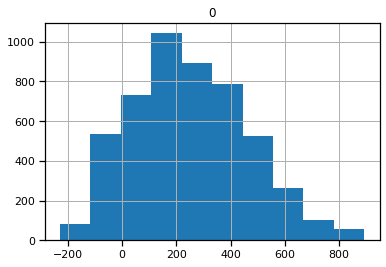

In [532]:
pd.DataFrame(y_predicted).hist()

 By applying all the features listed above, we can see that the model has improved significantly, however, from the distribution we can see that some of the y_predicted have negative value, meaning negative trips which does not make sense that needs to be excluded from the model calculation. We'll set all negative values to 0 after the model has made the predictions to make it more useful to our client.

## Setting Negative Values to 0

In [533]:
linear_rmse = rmse(np.where(y_predicted<0, 0, y_predicted) - y_val)
print(linear_rmse)

207.02825641774672


## Time Series Cross Validation

In this section, since the dataset is time sensitive, we will use time series cross validation to our model, using both the simple model as well as the linear model

In [534]:
trips_agg = aggregate_trips(trips)

train, test = train_test_split(trips_agg, train_size=0.7, 
                               test_size=0.3, random_state=0)

x_train, y_train = process_data(train, ['Hour', 'Month', 'Wind Dir'], 
                                ['Wind','Temp', 'Experienced Temp', 'Dew', 'RH', 'Pressure'], ['dow', 'Weather'],
                               mandatory_fields, weather_avg)

In [535]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import clone

In [536]:
def cross_validate_rmse(model, X, y):
     
    # Setup
    model = clone(model)
    time_split = TimeSeriesSplit(n_splits=12) 
    rmse_values = []
    
    for train_index, val_index in time_split.split(X):
                
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        
        model.fit(X_train, y_train)
        y_predicted = model.predict(X_val)   
        
        
        rmse_values.append(rmse(np.where(y_predicted<0, 0, y_predicted) - y_val))
        
    return rmse_values

Next linear model is used 

In [537]:
linear_rmse_cv = cross_validate_rmse(model=LinearRegression(fit_intercept=True), X=x_train, y=y_train)
print('Cross-validation Linear RMSE scores: {}'.format(linear_rmse_cv))
print('Cross-validation Linear RMSE scores mean: {}'.format(np.mean(linear_rmse_cv)))
print('Cross-validation Linear RMSE scores std: {}'.format(np.std(linear_rmse_cv)))

Cross-validation Linear RMSE scores: [218.50727430583567, 211.1856642209892, 207.20970664472554, 216.78307671555922, 202.7110443580722, 214.4568026070633, 215.03544094758487, 214.3124618289006, 213.6660359057456, 195.82983847925158, 220.3031178396028, 205.31350403284958]
Cross-validation Linear RMSE scores mean: 211.27616399051502
Cross-validation Linear RMSE scores std: 6.875851359243329


The RMSE score from time series cross validation also confirms that our linear model performs well with an mean score of 222, we will use this to apply to our test dataset  

## Feature Selection

If we want to only choose a limited feature set, and avoid incorporating features that tell the same information, or are not useful to the model (since they will imply meaning when it actually doesn't), we'll use the `SelectKBest` function, along with the chi squared indicator to select k statistically significant features. We will do this inside of our cross validation loop.

In [538]:
from sklearn.feature_selection import SelectKBest, chi2

In [539]:
def cross_validate_feature_selection_rmse(model, X, y, n):    
    
    # Setup
    model = clone(model)
    time_split = TimeSeriesSplit(n_splits=12) 
    rmse_values = []
    
    
    for train_index, val_index in time_split.split(X):
        
        select = SelectKBest(chi2, k = n).fit(X.iloc[train_index,:], y.iloc[train_index])
        
        X_new = pd.DataFrame(X.iloc[:, select.get_support()])
        
        model.fit(X_new.iloc[train_index, :], y.iloc[train_index])
        y_predicted = model.predict(X_new.iloc[val_index,:])   
        
        
        rmse_values.append(rmse(np.where(y_predicted<0, 0, y_predicted) - y.iloc[val_index]))
        
    return rmse_values

This is a very simple model, so it's not computationally heavy to iterate through all possible values of k, to see the best number.

In [540]:
l = []
for n in range(1,49,1):
    linear_rmse_cv = cross_validate_feature_selection_rmse(LinearRegression(), x_train, y_train, n)
    l.append([n, np.mean(linear_rmse_cv)])

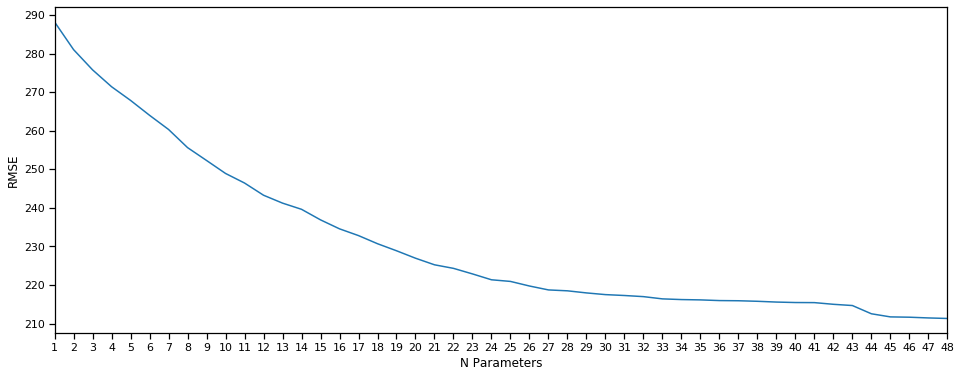

In [541]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=[16,6])

sns.lineplot(data = pd.DataFrame(l, columns = ['N Parameters', 'RMSE']), x = 'N Parameters', y = 'RMSE', ax = ax)

ax.set_xticks(range(49))
ax.set_xlim([1,48])

plt.show()

From the chart above, we can see 44 features seems like the optimal amount of features, beyond that is diminishing rewards.

In [542]:
from collections import Counter
import itertools

# Final Model Output

In [543]:
def final_model(model, X, y):    
    
    # Setup
    model = clone(model)
    time_split = TimeSeriesSplit(n_splits=12) 
    rmse_values = []
    list_features = []
    
    for train_index, val_index in time_split.split(X):
        
        select = SelectKBest(chi2, k = 44).fit(X.iloc[train_index,:], y.iloc[train_index])
        
        X_new = pd.DataFrame(X.iloc[:, select.get_support()])
        
        model.fit(X_new.iloc[train_index, :], y.iloc[train_index])
        y_predicted = model.predict(X_new.iloc[val_index,:])   
        
        
        rmse_values.append(rmse(np.where(y_predicted<0, 0, y_predicted) - y.iloc[val_index]))
        
        list_features.append(X_new.columns.to_list())
        
    flattened_list = list(itertools.chain(*list_features))
    
    chosen_fields = select.get_support()
    return rmse_values, flattened_list, chosen_fields, model

In [544]:
rmse_values, list_params, chosen_fields, model= final_model(LinearRegression(fit_intercept = True), x_train, y_train)

print(np.mean(rmse_values))
Counter(list_params)

212.5382746632715


Counter({'Temp': 12,
         'dow': 12,
         'Weather': 12,
         'Hour_0': 12,
         'Hour_1': 12,
         'Hour_2': 12,
         'Hour_3': 12,
         'Hour_4': 12,
         'Hour_5': 12,
         'Hour_6': 12,
         'Hour_7': 12,
         'Hour_8': 12,
         'Hour_9': 12,
         'Hour_10': 12,
         'Hour_11': 12,
         'Hour_12': 12,
         'Hour_13': 12,
         'Hour_14': 12,
         'Hour_15': 12,
         'Hour_16': 12,
         'Hour_17': 12,
         'Hour_18': 12,
         'Hour_19': 12,
         'Hour_20': 12,
         'Hour_21': 12,
         'Hour_22': 12,
         'Hour_23': 12,
         'Month_1': 12,
         'Month_2': 12,
         'Month_3': 12,
         'Month_4': 12,
         'Month_5': 12,
         'Month_6': 12,
         'Month_7': 12,
         'Month_8': 12,
         'Month_9': 12,
         'Month_10': 12,
         'Month_11': 12,
         'Month_12': 12,
         'Wind Dir_1': 12,
         'Wind Dir_2': 12,
         'Wind Dir_3': 1

The final parameters our process has chosen contains all 12 months, all 24 hours, wind direction, temperature, whether its a weekday or weekend/holiday, and whether there is precipitation at that hour. In feature selection combined with cross validation, we would normally choose whatever features has the most votes, but all 44 of our features received all votes for all cross validation steps (shown through counting the number of times a feature appears in our chosen features list).

We decided not to do hyper-parameter tuning since we stuck to our linear regression model, which only 1 hyper-parameter that we could manipulate (`fit-intercept`). 

#### Why Wind Direction and not Wind Speed?

Wind direction tells information about both speed and direction, since no wind direction implies a calm wind. In our data exploration, we saw a lot more east west travel (especially on the Martin Goodman Trail), so an east/west head/tailwind would impact ridership more than a north/south wind.

# Test Dataset 

Applying the model to test dataset as well as RMSE calculation with cross validation

In [545]:
x_test, y_test = process_data(test, ['Hour', 'Month', 'Wind Dir'], 
                                ['Wind','Temp', 'Experienced Temp', 'Dew', 'RH', 'Pressure'], ['dow', 'Weather'],
                               mandatory_fields, weather_avg)

In [546]:
y_predicted = model.predict(x_test.iloc[:, chosen_fields])   
rmse_test = rmse(np.where(y_predicted<0, 0, y_predicted) - y_test)

print('The test dataset RMSE is: ' + str(rmse_test))

The test dataset RMSE is: 210.19738891561695
